# Analyse des Clients E-commerce

Ce notebook présente l'analyse des clients pour un site e-commerce, en utilisant la segmentation RFM et l'analyse par cohortes.


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Chargement des données

In [21]:
ecommerce_file_path = '../data/db_customers.csv'
ecommerce_customers_df = pd.read_csv(ecommerce_file_path)
ecommerce_customers_df.head()

,Unnamed: 0,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,payment_type,payment_installments,payment_value,review_score,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name_english
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,credit_card,1.0,18.12,4,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,housewares
1,1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,voucher,1.0,2.00,4,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,housewares
2,2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,voucher,1.0,18.59,4,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,housewares
3,3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,boleto,1.0,141.46,4,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,perfumery
4,4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,credit_card,3.0,179.12,5,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,auto


## Exploration des données

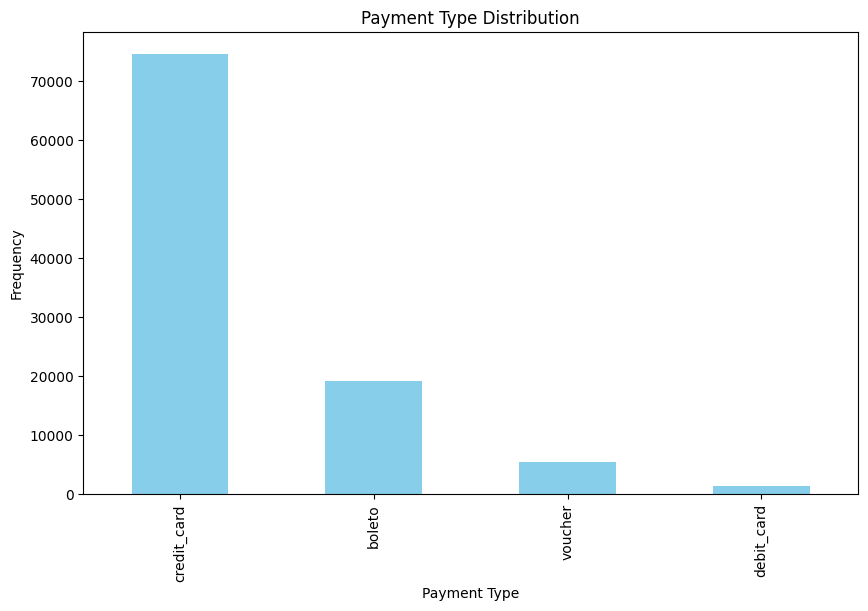

In [58]:
payment_type_counts = ecommerce_customers_df['payment_type'].value_counts()

plt.figure(figsize=(10, 6))
payment_type_counts.plot(kind='bar', color='skyblue')
plt.title('Payment Type Distribution')
plt.xlabel('Payment Type')
plt.ylabel('Frequency')
plt.show()

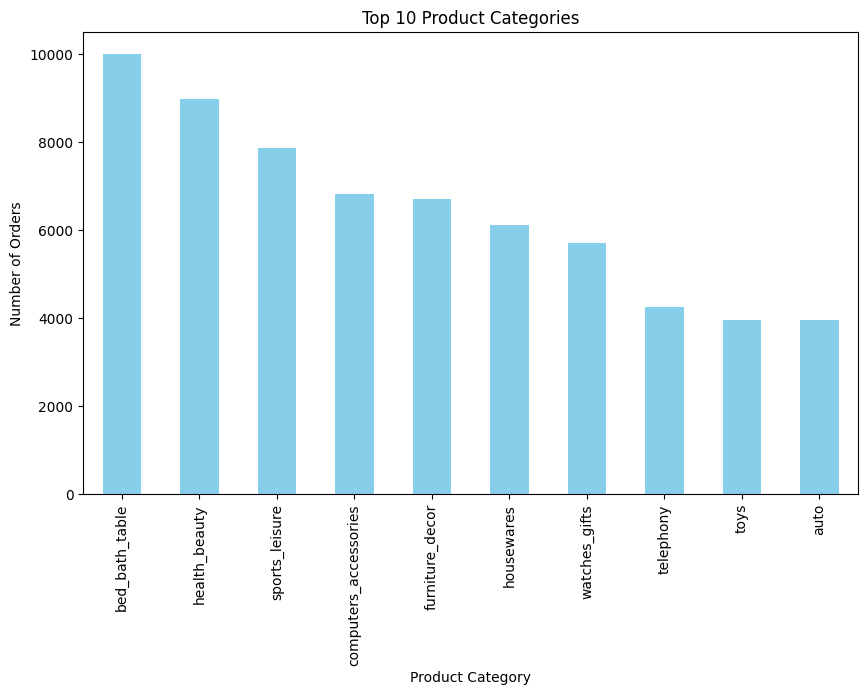

In [61]:
top_product_categories = ecommerce_customers_df['product_category_name_english'].value_counts().head(10)

plt.figure(figsize=(10, 6))
top_product_categories.plot(kind='bar', color='skyblue')
plt.title('Top 10 Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Number of Orders')
plt.show()

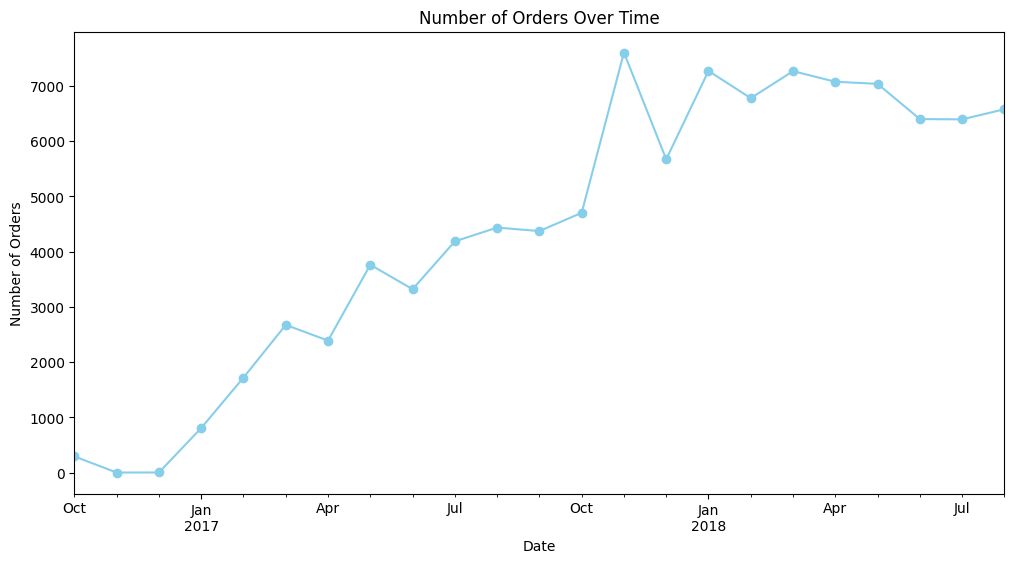

In [62]:
ecommerce_customers_df['order_purchase_timestamp'] = pd.to_datetime(ecommerce_customers_df['order_purchase_timestamp'])
orders_over_time = ecommerce_customers_df.set_index('order_purchase_timestamp').resample('M').size()

plt.figure(figsize=(12, 6))
orders_over_time.plot(kind='line', marker='o', color='skyblue')
plt.title('Number of Orders Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()

## Nettoyage des données

### Vérification des valeurs manquantes

In [22]:
missing_values = ecommerce_customers_df.isnull().sum()
missing_values

Unnamed: 0                          0
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_delivered_customer_date    3159
payment_type                        1
payment_installments                1
payment_value                       1
review_score                        0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
product_category_name_english    2410
dtype: int64

In [23]:
ecommerce_customers_df.dropna(inplace=True)

### Vérification des doublons

In [24]:
duplicate_rows = ecommerce_customers_df[ecommerce_customers_df.duplicated()]
duplicate_rows

,Unnamed: 0,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,payment_type,payment_installments,payment_value,review_score,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name_english


## Segmentation RFM

### Préparation des données pour la segmentation RFM

In [25]:
import datetime as dt

ecommerce_customers_df['order_purchase_timestamp'] = pd.to_datetime(ecommerce_customers_df['order_purchase_timestamp'])
snapshot_date = ecommerce_customers_df['order_purchase_timestamp'].max() + dt.timedelta(days=1)

### Calcul des valeurs RFM

In [26]:
rfm_table = ecommerce_customers_df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,
    'order_id': 'nunique',
    'payment_value': 'sum'
}).reset_index()

rfm_table.rename(columns={
    'order_purchase_timestamp': 'Recency',
    'order_id': 'Frequency',
    'payment_value': 'MonetaryValue'
}, inplace=True)
rfm_table.head()

,customer_unique_id,Recency,Frequency,MonetaryValue
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19
2,0000f46a3911fa3c0805444483337064,537,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89


### Calcul des scores RFM

In [29]:
rfm_table['R_Score'] = pd.qcut(rfm_table['Recency'], 5, ['5', '4', '3', '2', '1'])
rfm_table['F_Score'] = pd.qcut(rfm_table['Frequency'].rank(method='first'), 5, ['1', '2', '3', '4', '5'])
rfm_table['M_Score'] = pd.qcut(rfm_table['MonetaryValue'], 5, ['1', '2', '3', '4', '5'])

rfm_table['RFM_Segment'] = rfm_table['R_Score'].astype(str) + rfm_table['F_Score'].astype(str) + rfm_table['M_Score'].astype(str)
rfm_table['RFM_Score'] = rfm_table[['R_Score', 'F_Score', 'M_Score']].sum(axis=1).astype(int)

rfm_table.head()

,customer_unique_id,Recency,Frequency,MonetaryValue,R_Score,F_Score,M_Score,RFM_Score,RFM_Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,4,1,4,414,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,4,1,1,411,411
2,0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,112,112
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,2,1,1,211,211
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,4,214,214


In [52]:
def assign_segment(rfm_segment):
    if rfm_segment == '555':
        return 'Champions'
    elif rfm_segment in ['554', '545', '544', '543', '534', '535', '553', '552', '551']:
        return 'Loyaux'
    elif rfm_segment in ['544', '543', '542', '533', '532', '531', '522', '521', '532']:
        return 'Loyalistes potentiels'
    elif rfm_segment in ['511', '512', '521', '522', '513', '523', '514', '524']:
        return 'Récents'
    elif rfm_segment in ['441', '442', '431', '432', '421', '422']:
        return 'Prometteurs'
    elif rfm_segment in ['333', '334', '343', '344', '353', '354']:
        return 'A surveiller'
    elif rfm_segment in ['311', '312', '313', '321', '322', '323', '331', '332', '313']:
        return 'A réactiver'
    elif rfm_segment in ['223', '224', '233', '234', '243', '244', '333', '334', '343']:
        return 'A risque'
    elif rfm_segment in ['211', '212', '221', '222', '231', '232', '233']:
        return 'A ne pas perdre'
    elif rfm_segment in ['233', '234', '243', '244', '223', '224']:
        return 'En sommeil'
    elif rfm_segment in ['111', '112', '113', '114', '121', '122', '131', '132', '113', '114', '123', '124']:
        return 'Perdus'
    else:
        return 'Autres'

In [33]:
rfm_table['Segment'] = rfm_table.apply(assign_segment, axis=1)

print(rfm_table.head())

                 customer_unique_id  Recency  Frequency  MonetaryValue  \
0  0000366f3b9a7992bf8c76cfdf3221e2      112          1         141.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      115          1          27.19   
2  0000f46a3911fa3c0805444483337064      537          1          86.22   
3  0000f6ccb0745a6a4b88665a16c9f078      321          1          43.62   
4  0004aac84e0df4da2b147fca70cf8255      288          1         196.89   

  R_Score F_Score M_Score  RFM_Score RFM_Segment      Segment  
0       4       1       4        414         414       Autres  
1       4       1       1        411         411  A réactiver  
2       1       1       2        112         112       Perdus  
3       2       1       1        211         211       Perdus  
4       2       1       4        214         214       Autres  


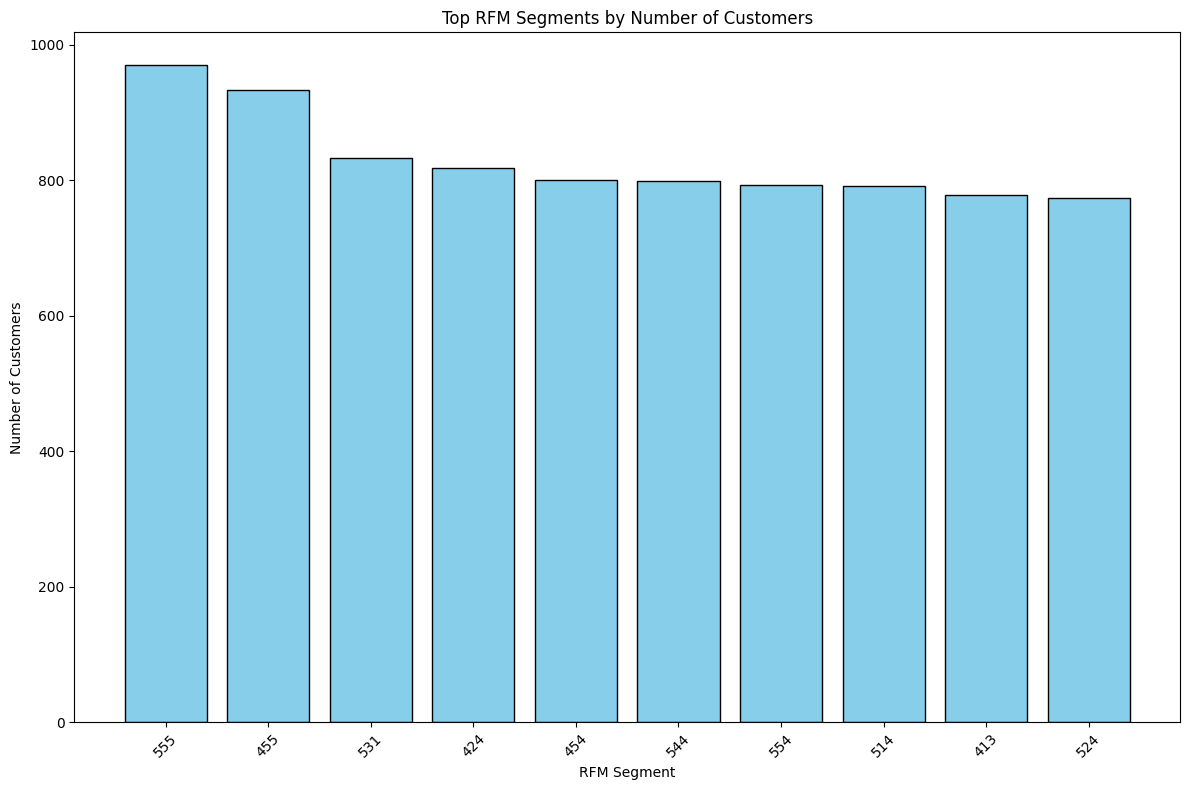

In [63]:
rfm_segments = rfm_table.groupby('RFM_Segment').size().reset_index(name='num_customers')

# Sort segments by the number of customers
top_segments = rfm_segments.sort_values(by='num_customers', ascending=False)

# Filter for top segments
best_segments = top_segments[top_segments['RFM_Segment'].str.startswith('5') |
                             top_segments['RFM_Segment'].str.startswith('4')].head(10)

# Plotting the top segments
fig, ax = plt.subplots(figsize=(12, 8))

# Bar plot of the top segments
ax.bar(best_segments['RFM_Segment'], best_segments['num_customers'], color='skyblue', edgecolor='black')
ax.set_title('Top RFM Segments by Number of Customers')
ax.set_xlabel('RFM Segment')
ax.set_ylabel('Number of Customers')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

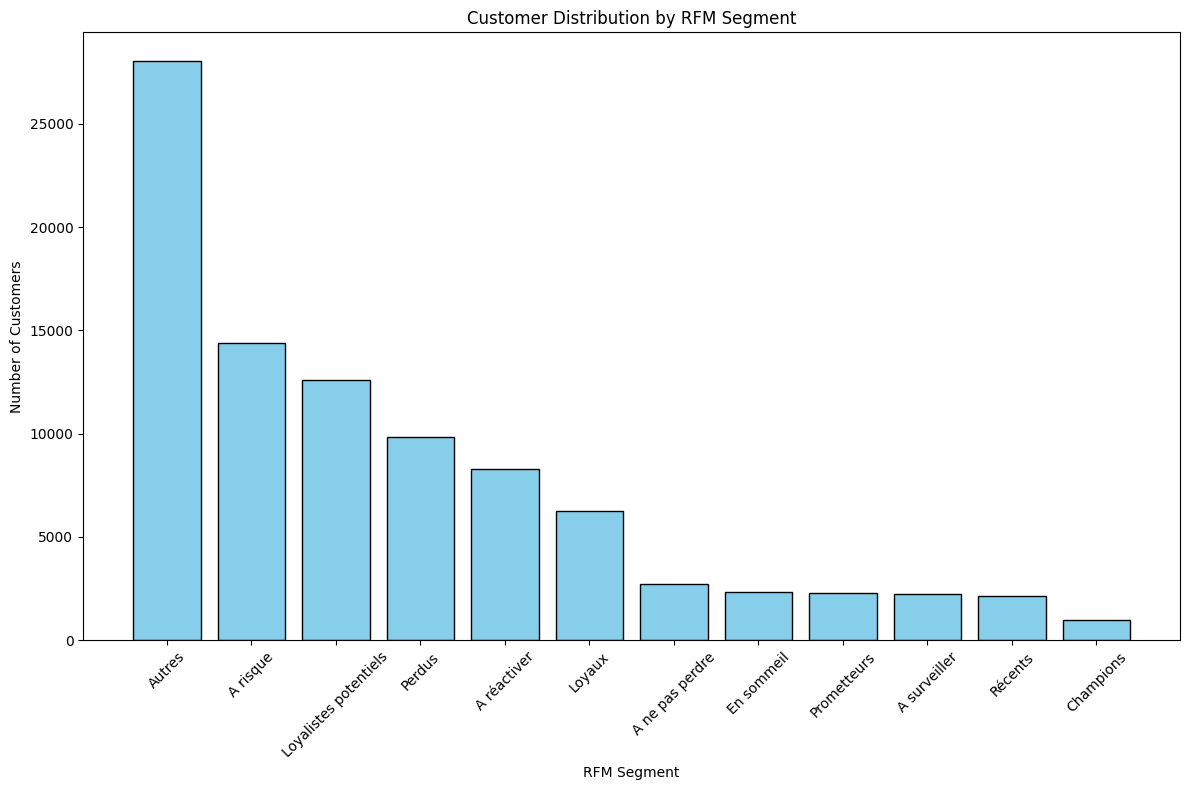

In [53]:
segment_counts = rfm_table['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Number of Customers']

# Plotting the segment distribution
fig, ax = plt.subplots(figsize=(12, 8))

# Bar plot of the segments
ax.bar(segment_counts['Segment'], segment_counts['Number of Customers'], color='skyblue', edgecolor='black')
ax.set_title('Customer Distribution by RFM Segment')
ax.set_xlabel('RFM Segment')
ax.set_ylabel('Number of Customers')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

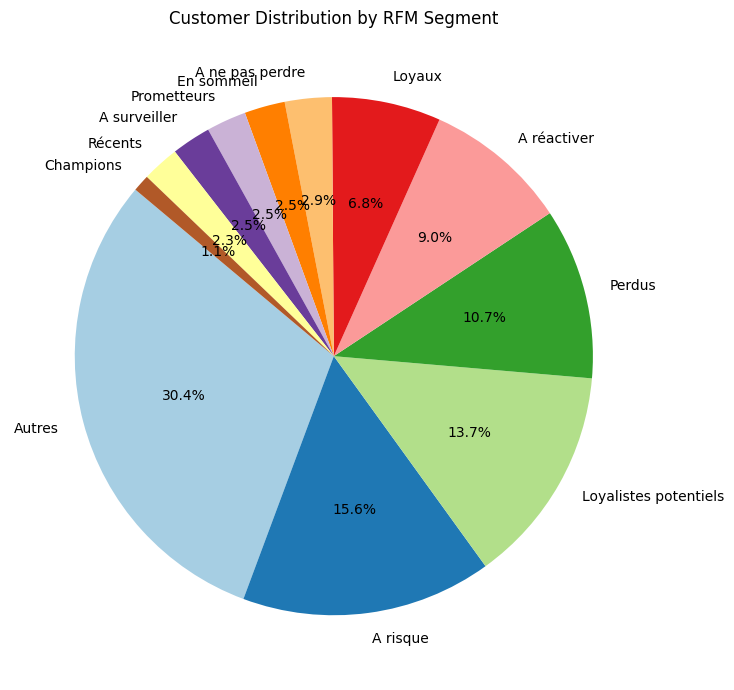

In [55]:
# Plotting the segment distribution as a pie chart
fig, ax = plt.subplots(figsize=(10, 7))

# Pie chart of the segments
ax.pie(segment_counts['Number of Customers'], labels=segment_counts['Segment'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
ax.set_title('Customer Distribution by RFM Segment')

plt.tight_layout()
plt.show()

In [54]:
segment_counts = rfm_table['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Number of Customers']

print(segment_counts)

                  Segment  Number of Customers
0                  Autres                28026
1                A risque                14392
2   Loyalistes potentiels                12592
3                  Perdus                 9830
4             A réactiver                 8291
5                  Loyaux                 6261
6         A ne pas perdre                 2699
7              En sommeil                 2333
8             Prometteurs                 2289
9            A surveiller                 2257
10                Récents                 2136
11              Champions                  970


In [44]:
others_details = rfm_table[rfm_table['Segment'] == 'Autres']

print(others_details[['customer_unique_id', 'R_Score', 'F_Score', 'M_Score', 'RFM_Segment']])

                     customer_unique_id R_Score F_Score M_Score RFM_Segment
0      0000366f3b9a7992bf8c76cfdf3221e2       4       1       4         414
4      0004aac84e0df4da2b147fca70cf8255       2       1       4         214
5      0004bd2a26a76fe21f786e4fbd80607f       4       1       4         414
7      00053a61a98854899e70ed204dd4bafe       3       1       5         315
8      0005e1862207bf6ccc02e4228effd9a0       1       1       4         114
...                                 ...     ...     ...     ...         ...
92061  fff22793223fe80c97a8fd02ac5c6295       5       5       3         553
92064  fff3e1d7bc75f11dc7670619b2e61840       5       5       2         552
92068  fff96bc586f78b1f070da28c4977e810       5       5       2         552
92070  fffb09418989a0dbff854a28163e47c6       3       5       2         352
92072  fffea47cd6d3cc0a88bd621562a9d061       3       5       2         352

[28026 rows x 5 columns]


Segment 555 a le plus grand nombre de clients, indiquant qu'il s'agit du groupe le plus précieux avec des clients très récents, fréquents et ayant des dépenses élevées.
Les segments 455 et 554 sont également importants avec un grand nombre de clients récents et à forte valeur.

Actions Recommandées :
Programmes de Fidélité : Renforcer les relations avec les clients des segments 555 et 455 en offrant des récompenses pour leur fidélité.
Offres Exclusives : Proposer des promotions spéciales aux segments 424 et 433 pour augmenter leur fréquence d'achat.
Promotions Ciblées : Encourager les segments comme 531 à dépenser plus avec des incitations spécifiques.

## Analyse par Cohortes

### Définir les cohortes

In [ ]:
ecommerce_customers_df['order_month'] = ecommerce_customers_df['order_purchase_timestamp'].dt.to_period('M')
ecommerce_customers_df['cohort'] = ecommerce_customers_df.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')

### Calculer les cohortes

In [ ]:
cohort_data = ecommerce_customers_df.groupby(['cohort', 'order_month']).agg({
    'customer_unique_id': 'nunique'
}).reset_index().rename(columns={'customer_unique_id': 'NumCustomers'})

cohort_pivot = cohort_data.pivot_table(index='cohort', columns='order_month', values='NumCustomers')
cohort_pivot

order_month,2016-10,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08
cohort,,,,,,,,,,,,,,,,,,,,,
2016-10,265.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,...,1.0,NaN,1.0,NaN,1.0,NaN,2.0,2.0,NaN,NaN
2016-12,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,NaN,NaN,708.0,2.0,2.0,1.0,3.0,1.0,3.0,1.0,...,3.0,1.0,4.0,3.0,1.0,1.0,2.0,3.0,NaN,1.0
2017-02,NaN,NaN,NaN,1581.0,3.0,5.0,1.0,7.0,2.0,4.0,...,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,3.0,NaN
2017-03,NaN,NaN,NaN,NaN,2456.0,11.0,9.0,9.0,9.0,4.0,...,8.0,2.0,8.0,3.0,5.0,3.0,4.0,6.0,2.0,3.0
2017-04,NaN,NaN,NaN,NaN,NaN,2195.0,14.0,5.0,4.0,6.0,...,7.0,7.0,4.0,6.0,2.0,1.0,1.0,2.0,2.0,3.0
2017-05,NaN,NaN,NaN,NaN,NaN,NaN,3373.0,16.0,15.0,10.0,...,14.0,5.0,8.0,8.0,9.0,10.0,8.0,1.0,5.0,7.0
2017-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2987.0,15.0,11.0,...,12.0,10.0,7.0,4.0,5.0,9.0,10.0,5.0,5.0,7.0
2017-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3707.0,20.0,...,10.0,8.0,12.0,4.0,7.0,10.0,8.0,11.0,5.0,9.0


### Calculer la rétention

In [ ]:
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
retention_matrix

order_month,2016-10,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08
cohort,,,,,,,,,,,,,,,,,,,,,
2016-10,1.0,NaN,NaN,NaN,NaN,0.003774,NaN,NaN,0.003774,NaN,...,0.003774,NaN,0.003774,NaN,0.003774,NaN,0.007547,0.007547,NaN,NaN
2016-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Visualiser la rétention

/Users/guillaumedemerges/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


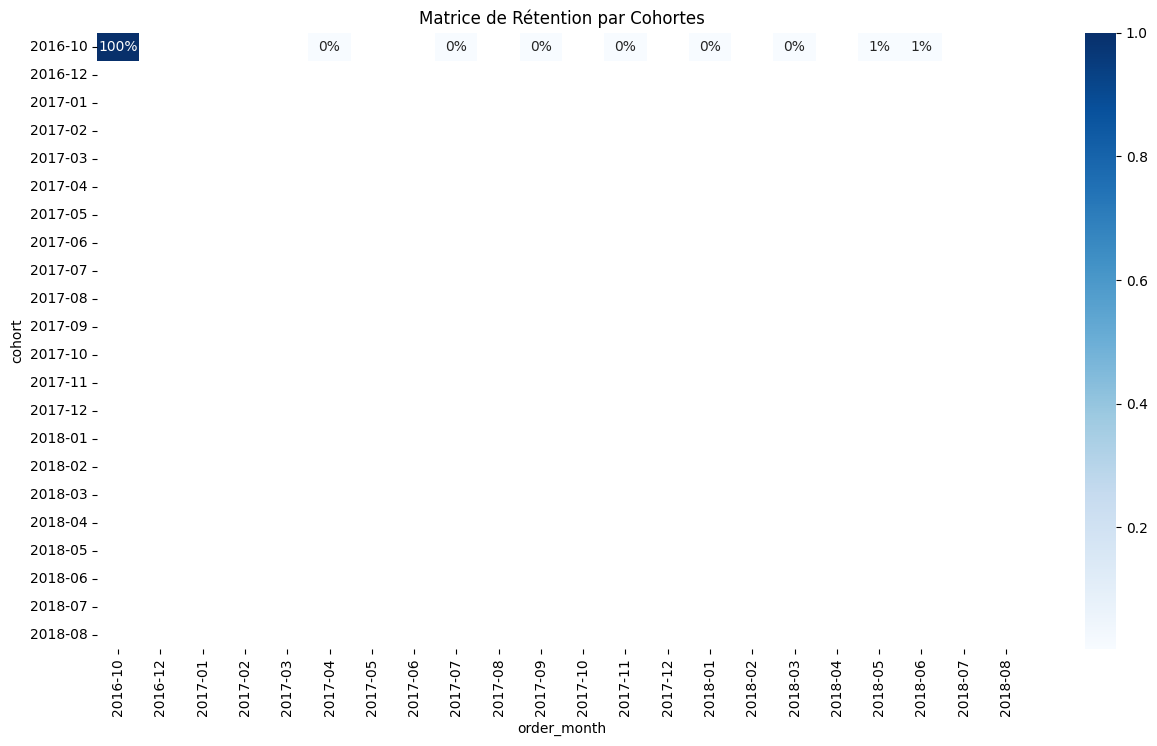

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
sns.heatmap(retention_matrix, annot=True, fmt='.0%', cmap='Blues')
plt.title('Matrice de Rétention par Cohortes')
plt.show()